<a href="https://colab.research.google.com/github/Satyam-kumar-yadav/EfficientNetB5_breed_pred/blob/main/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/My Drive/Snake_breed/snake.zip" -d "/content/drive/My Drive/Snake_breed"

Archive:  /content/drive/My Drive/Snake_breed/snake.zip
^C


In [ ]:
import cv2
import glob
import numpy as np
import pandas as pd
import shutil
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.filters import sobel

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dense,Flatten,Dropout,AvgPool2D
from keras.layers.normalization import BatchNormalization
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

In [ ]:
labels=pd.read_csv('/content/drive/My Drive/Snake_breed/dataset/train.csv')
labels.head()

,image_id,breed
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix


In [ ]:
breeds=list(labels['breed'].unique())
len(breeds)

35

In [ ]:
## dividing the train data into different folders according to their breed names
os.mkdir('/content/drive/My Drive/Snake_breed/dataset/new_train')

for i in range(len(labels)):
    if labels['breed'][i] not in os.listdir('/content/drive/My Drive/Snake_breed/dataset/new_train'):
        os.mkdir('/content/drive/My Drive/Snake_breed/dataset/new_train/'+labels['breed'][i])
    shutil.copy('/content/drive/My Drive/Snake_breed/dataset/train/'+labels['image_id'][i]+'.jpg', '/content/drive/My Drive/Snake_breed/dataset/new_train/'+labels['breed'][i])

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
# from keras.applications.resnet50 import preprocess_input

image_size=128
image_path='/content/drive/My Drive/Snake_breed/dataset/new_train/'

train_datagen=ImageDataGenerator(
                        rescale=1./255,
                        validation_split=0.1,
                        horizontal_flip=True,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        rotation_range=40,
                        fill_mode='nearest'
                        )

train_generator=train_datagen.flow_from_directory(
                        image_path, 
                        target_size=(image_size,image_size),
                        subset='training',
                        shuffle=True,
                        batch_size=128,
                        class_mode='categorical'
                        )

valid_datagen=ImageDataGenerator(
                        validation_split=0.1,
                        rescale=1./255
                        )

valid_generator=valid_datagen.flow_from_directory(
                        image_path, 
                        target_size=(image_size,image_size),
                        subset='validation',
                        shuffle=False,
                        batch_size=128,
                        class_mode='categorical'
                        )

Found 4973 images belonging to 35 classes.
Found 535 images belonging to 35 classes.


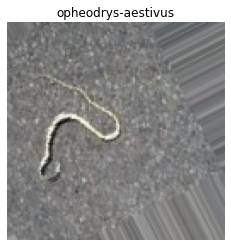

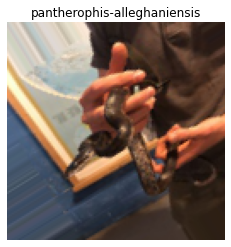

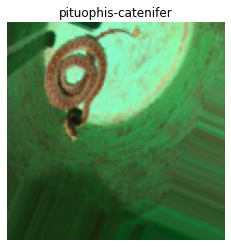

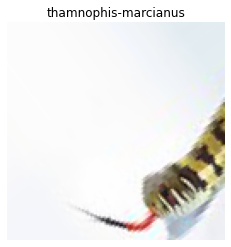

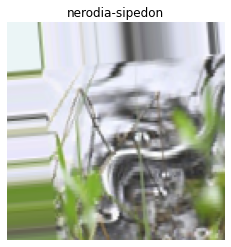

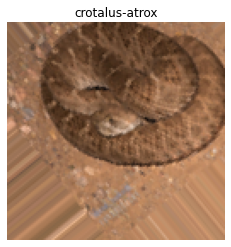

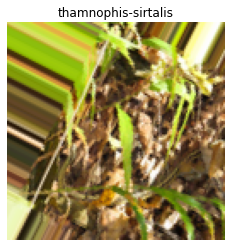

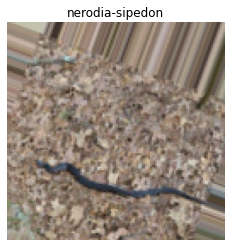

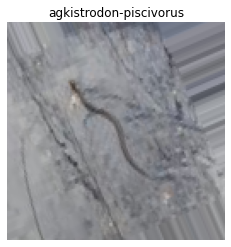

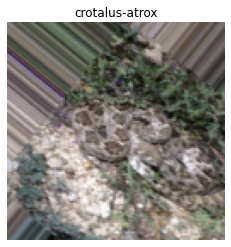

In [ ]:
x,y = train_generator.next()
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)
for i in range(0,10):
    image = x[i]
    plt.imshow(image)
    # plt.imshow((image * 255).astype(np.uint8))
    c=0
    for i in y[i]:
        if i==0:
            c+=1
        else:break
    label=labels[c]
    label=label.replace('_',' ')
    label=label.lower()
    plt.title(label)
    plt.axis('off')
    plt.show()

In [ ]:
# path = 'content/drive/My Drive/Snake_breed/dataset/image/'
# img_dict = dict()

# for root, dirs, files in os.walk(path):
#     print(os.path.basename(root))
#     my_key = os.path.basename(root)

#     dir_images = []
#     for file_ in files:
#         full_file_path = os.path.join(root, file_)
#         img = cv2.imread(full_file_path)
#         img = cv2.resize(img , (224 , 224))
#         dir_images.append(img)

#     img_dict[my_key] = dir_images

In [ ]:
# for i in glob.iglob('/content/drive/My Drive/Snake_breed/dataset/image/**/*.jpg' ,  recursive = True):
#   # img = cv2.imread(i)
#   # img = cv2.resize(img , (224 , 224))
#   print(i)


In [ ]:
# !unzip "/content/drive/My Drive/Snake_breed/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5.zip" -d "/content/drive/My Drive/Snake_breed/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

Archive:  /content/drive/My Drive/Snake_breed/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5.zip
  inflating: /content/drive/My Drive/Snake_breed/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5  


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3



Inception = InceptionV3(input_shape = (128,128,3), 
                                 include_top = False, 
                                 weights = 'imagenet')

model2=Sequential()
model2.add(Inception)
model2.add(GlobalAveragePooling2D())
model2.add(Flatten())
model2.add(Dense(512,activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(len(breeds),activation='softmax'))

model2.layers[0].trainable=False

model2.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001) , 
              
             loss='categorical_crossentropy',
             metrics=['accuracy']
             )

model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 35)                17955     
Total params: 22,869,827
Trainable params: 1,067,043
Non-trainable params: 21,802,784
__________________________________

In [ ]:
!nvidia-smi

Tue Nov 10 13:58:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W /  70W |    483MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5,min_delta=0,mode='auto',restore_best_weights=False,baseline=None)

history=model2.fit(train_generator,
                   steps_per_epoch=None,
                   epochs=100,
                   validation_data=valid_generator,
                   validation_steps=4,
                   callbacks=[callback])

In [ ]:
# os.mkdir('/content/drive/My Drive/Snake_breed/models/')
model2.save('/content/drive/My Drive/Snake_breed/model1/new_upgrad.h5')


In [ ]:
def plot_model(history):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
    fig.suptitle('Model Accuracy and Loss')

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.title.set_text('Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train','Valid'],loc=4)

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.title.set_text('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train','Valid'],loc=1)

    fig.show()

plot_model(history)

In [ ]:
os.mkdir('/content/drive/My Drive/Snake_breed/dataset/new_test')
os.mkdir('/content/drive/My Drive/Snake_breed/dataset/new_test/test')
test_images=os.listdir('/content/drive/My Drive/Snake_breed/dataset/test/')

for i in range(len(test_images)):
    shutil.copy('/content/drive/My Drive/Snake_breed/dataset/test/'+test_images[i],'/content/drive/My Drive/Snake_breed/dataset/new_test/test')

In [ ]:
test_generator = valid_datagen.flow_from_directory(
    '/content/drive/My Drive/Snake_breed/dataset/new_test/',
    target_size=(224,224),
    color_mode="rgb",
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 2361 images belonging to 1 classes.


In [ ]:
test_generator.reset()
pred=model2.predict(test_generator,verbose=1,steps=2361/32)

74/73 [==============================] - 6s 83ms/step


In [ ]:
n = len(labels)
n_class = len(breeds)  
class_to_num = dict(zip(breeds, range(n_class)))
num_to_class = dict(zip(range(n_class), breeds))

df2 = pd.read_csv('/content/drive/My Drive/Snake_breed/dataset/test.csv')

for b in breeds:
    df2[b] = pred[:,class_to_num[b]]
    

df2.to_csv('pred.csv', index=None)

In [ ]:
df_4 = pd.read_csv('/content/pred.csv')
df_4.head()

,image_id,nerodia-erythrogaster,pantherophis-vulpinus,thamnophis-sirtalis,pantherophis-obsoletus,agkistrodon-contortrix,crotalus-atrox,lampropeltis-triangulum,crotalus-horridus,crotalus-ruber,heterodon-platirhinos,nerodia-sipedon,thamnophis-elegans,thamnophis-marcianus,crotalus-viridis,nerodia-fasciata,haldea-striatula,storeria-dekayi,agkistrodon-piscivorus,nerodia-rhombifer,storeria-occipitomaculata,thamnophis-radix,coluber-constrictor,natrix-natrix,diadophis-punctatus,masticophis-flagellum,pantherophis-spiloides,rhinocheilus-lecontei,lampropeltis-californiae,pituophis-catenifer,opheodrys-aestivus,pantherophis-guttatus,pantherophis-alleghaniensis,thamnophis-proximus,pantherophis-emoryi,crotalus-scutulatus
0,7ede553357,0.027539,0.034582,0.008659,0.009257,0.022608,0.020504,0.058973,0.100759,0.052824,0.035378,0.039396,0.005585,0.025362,0.018604,0.022032,0.016489,0.020306,0.020385,0.047906,0.008832,0.017553,0.017691,0.014029,0.014701,0.027359,0.024172,0.014394,0.022562,0.018914,0.031378,0.051005,0.054750,0.030626,0.026574,0.038313
1,3500b219e4,0.023776,0.118035,0.002746,0.026499,0.015670,0.017492,0.025095,0.077730,0.020033,0.009639,0.041890,0.009918,0.075445,0.009424,0.028873,0.023397,0.002815,0.010234,0.038547,0.006913,0.006710,0.010603,0.049022,0.037653,0.031741,0.018901,0.003859,0.028131,0.049057,0.019175,0.043383,0.036172,0.038597,0.015787,0.027037
2,d43a78d6d9,0.021031,0.046731,0.005830,0.023942,0.028284,0.015306,0.069633,0.039530,0.013860,0.023558,0.067644,0.011513,0.022853,0.028984,0.036343,0.035593,0.018540,0.007999,0.069874,0.012242,0.016818,0.023008,0.008739,0.030033,0.023915,0.021392,0.008930,0.075087,0.020911,0.022929,0.036087,0.043915,0.012730,0.037273,0.018941
3,1f36f26994,0.006166,0.019785,0.001452,0.006070,0.003249,0.002335,0.455820,0.141242,0.001006,0.009928,0.079885,0.023753,0.016441,0.003239,0.006655,0.005902,0.000509,0.013009,0.008503,0.000825,0.001088,0.005933,0.030122,0.028052,0.006419,0.013632,0.001375,0.007588,0.015363,0.015822,0.004064,0.020702,0.004923,0.005790,0.033352
4,8cb85fc58e,0.051904,0.026497,0.004749,0.051337,0.037569,0.010378,0.012290,0.079800,0.027048,0.013249,0.085558,0.023141,0.034372,0.061350,0.026039,0.014877,0.004718,0.005920,0.051221,0.008171,0.009730,0.020156,0.019827,0.025015,0.032992,0.014581,0.010541,0.015436,0.017007,0.019299,0.026514,0.057069,0.024394,0.020530,0.056720


In [ ]:
submission = pd.DataFrame(df_4['image_id'])
data_max = df_4.drop('image_id' , axis = 1)
submission['breed'] = data_max.idxmax(axis = 1)

In [ ]:
submission.head()

,image_id,breed
0,7ede553357,crotalus-horridus
1,3500b219e4,pantherophis-vulpinus
2,d43a78d6d9,lampropeltis-californiae
3,1f36f26994,lampropeltis-triangulum
4,8cb85fc58e,nerodia-sipedon


In [ ]:
submission.to_csv('prediction.csv' , index=None)